<a href="https://colab.research.google.com/github/Chirag5683/Image-Classification-CIFAR-10/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Preparing CIFAR-10 Dataset

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,".")

Using downloaded and verified file: ./cifar10.tgz


In [3]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['test', 'train']
['dog', 'frog', 'deer', 'truck', 'ship', 'automobile', 'cat', 'horse', 'airplane', 'bird']


In [5]:
#Data Transforms and augmentation
'''(mean, standard deviation) of three channels rgb'''
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(p=0.5),
                         #tt.RandomRotation(degrees=30),
                        #  tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1,1)),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats, inplace=True)])

In [6]:
# PyTorch Datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [7]:
batch_size = 400

In [8]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [9]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_batches(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        '''clamp(0,1) use : Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).'''
        break


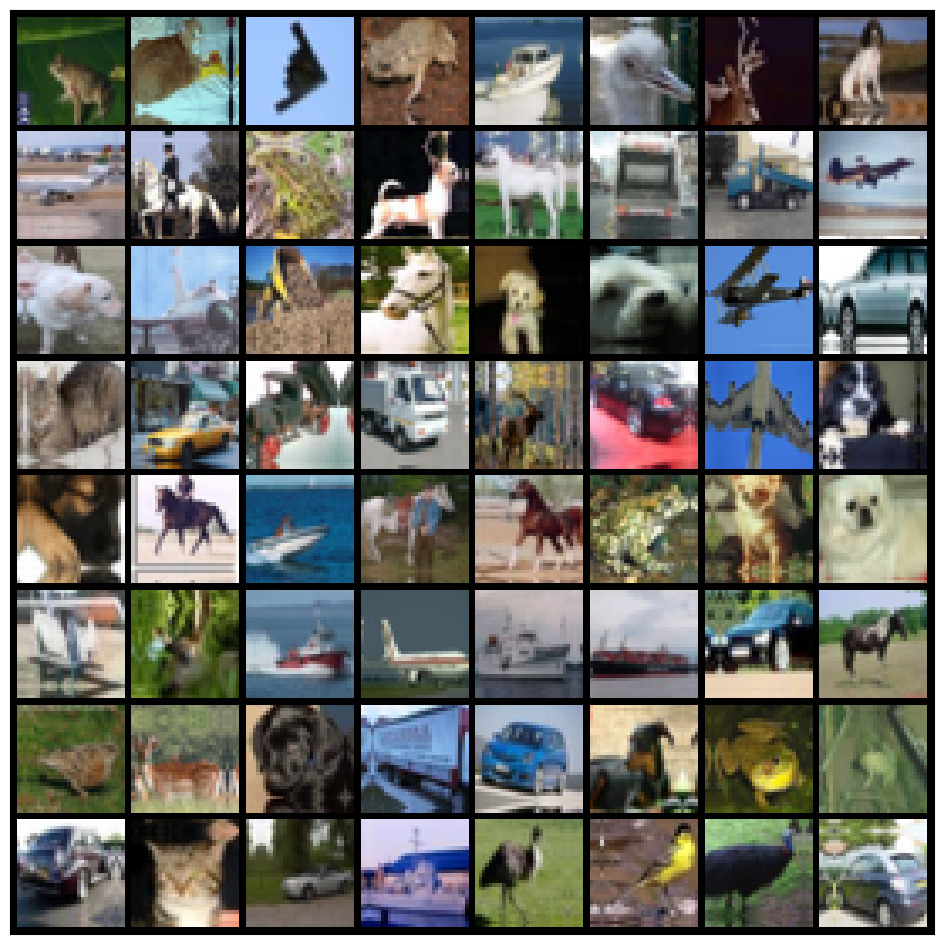

In [10]:
show_batches(train_dl)

## Using a GPU

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        #return number of batches
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization



One of the key feature to our CNN model is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)



In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

We will use the ResNet9 architecture:
![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the Model



Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3067893981933594, 'val_acc': 0.08769231289625168}]

In [21]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 1.5124, val_loss: 1.2073, val_acc: 0.5895
Epoch [1], last_lr: 0.00759, train_loss: 1.0684, val_loss: 1.0361, val_acc: 0.6776
Epoch [2], last_lr: 0.01000, train_loss: 0.8923, val_loss: 0.7984, val_acc: 0.7406
Epoch [3], last_lr: 0.00950, train_loss: 0.6799, val_loss: 0.6202, val_acc: 0.7762
Epoch [4], last_lr: 0.00812, train_loss: 0.5584, val_loss: 0.9051, val_acc: 0.6922
Epoch [5], last_lr: 0.00611, train_loss: 0.4581, val_loss: 0.5735, val_acc: 0.8011
Epoch [6], last_lr: 0.00389, train_loss: 0.3780, val_loss: 0.4873, val_acc: 0.8370
Epoch [7], last_lr: 0.00188, train_loss: 0.2972, val_loss: 0.3820, val_acc: 0.8762
Epoch [8], last_lr: 0.00050, train_loss: 0.2120, val_loss: 0.2730, val_acc: 0.9047
Epoch [9], last_lr: 0.00000, train_loss: 0.1601, val_loss: 0.2606, val_acc: 0.9130
CPU times: user 27.9 s, sys: 4.47 s, total: 32.4 s
Wall time: 6min 21s


In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

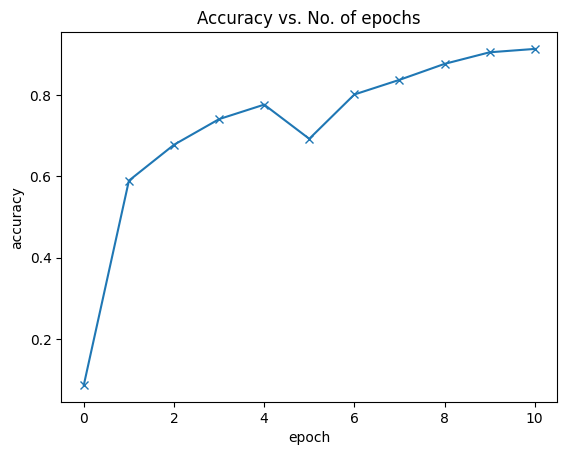

In [24]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

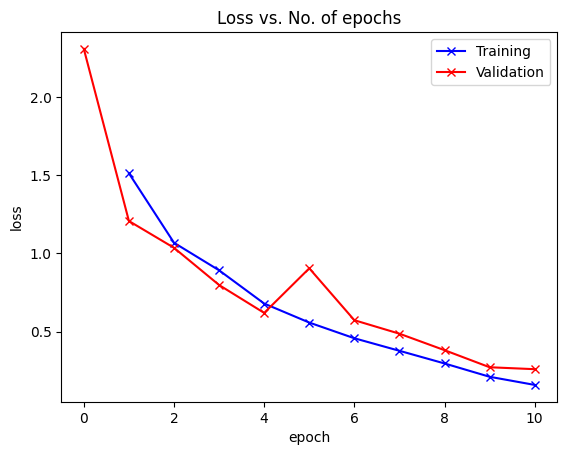

In [26]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [27]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

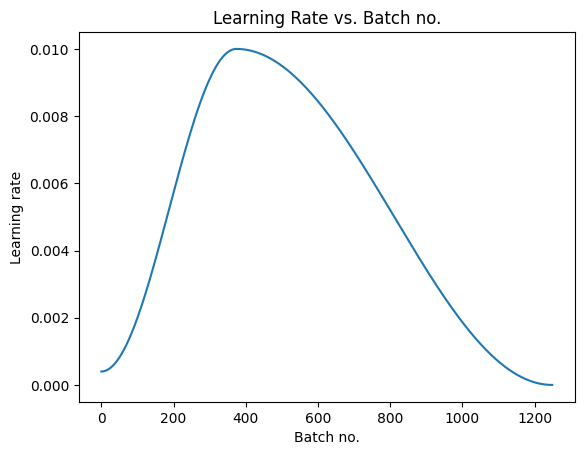

In [28]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.


In [29]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


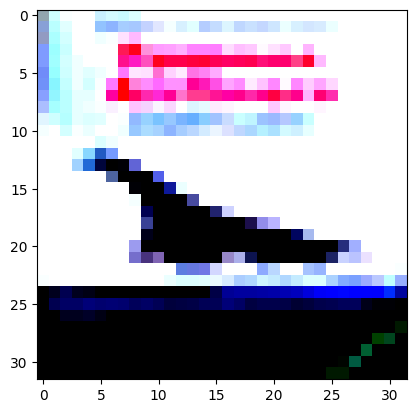

In [30]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


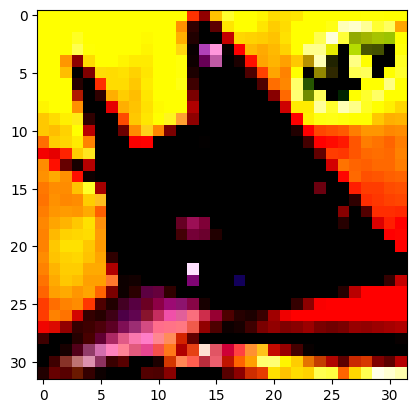

In [31]:
img, label = valid_ds[420]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: truck , Predicted: truck


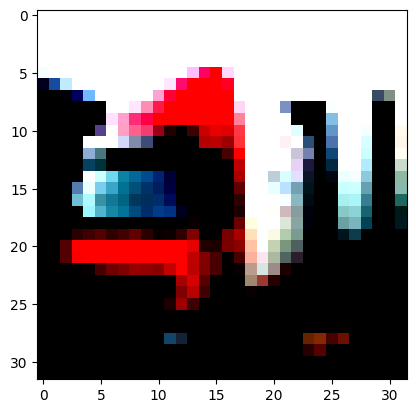

In [32]:
img, label = valid_ds[9999]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [33]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')